# Operacje morfologiczne
Opracowanie: A.Florkowska

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.ndimage as nd
from skimage import io
from skimage import color
import time
from IPython.display import Image

# Progowanie - tworzenie obrazów binarnych
Obraz binarny to taki, którego wartości do 0 lub 1, czyli jest po prostu czarno - biały. Jeśli chcemy zamienić dane na obraz wejściowy to musimy je najpierw przekonwertować do skali szarości, a następnie zmodyfikować wartości, tak aby finalny obraz składał się tylko z 0 i 1. 

Ale w jaki sposób?

Służy temu operacja progowania. Intensywności na obrazie mogą być w skali [0,1] lub [0,255]. na początku musi wybrać jakąś wartość progu - wszystkie piksele, których wartość jest niższa niż próg dostaną wartość 0 (tło), a większe 1 (obiekt). Jest to tzw. proste progowanie, który jest jednym z rodzajów segmentacji - ale o tym w późniejszych notatnikach.

Bardzo ciężko jest czasem jednoznacznie wyznaczyć poziom progu, dlatego często się zdarza, że wynikowe obrazy zawierają szum.

Minimum value 0.0 and maximum value 1.0


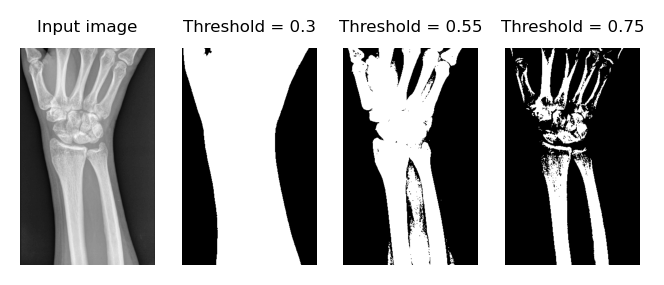

In [44]:
normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

print(f"Minimum value {np.min(image)} and maximum value {np.max(image)}")

simple_thresholding = lambda image, threshold: image > threshold

output1 = simple_thresholding(image, 0.3)
output2 = simple_thresholding(image, 0.55)
output3 = simple_thresholding(image, 0.75)

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 4, 2)
plt.imshow(output1, cmap='gray')
plt.axis('off')
plt.title("Threshold = 0.3", fontsize=6)
plt.subplot(1, 4, 3)
plt.imshow(output2, cmap='gray')
plt.axis('off')
plt.title("Threshold = 0.55", fontsize=6)
plt.subplot(1, 4, 4)
plt.imshow(output3, cmap='gray')
plt.axis('off')
plt.title("Threshold = 0.75", fontsize=6)
plt.show()

Zacznijmy od wygenerowania kilku podstawowych kształtów geometrycznych.

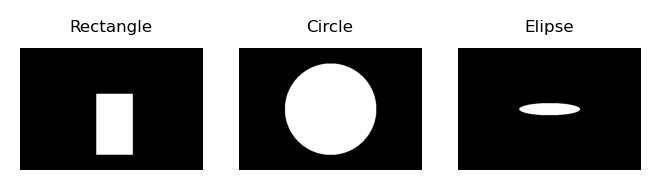

In [30]:
def generate_rectangle(x_size, y_size, x_b, y_b, width, heigth):
    image = np.zeros((y_size, x_size))
    image[y_b : y_b + heigth, x_b : x_b + width] = 1
    return image

def generate_circle(x_size, y_size, x_origin, y_origin, radius):
    xx, yy = np.meshgrid(np.arange(x_size), np.arange(y_size))
    circle_mask = lambda x, y, x_origin, y_origin, radius: (x - x_origin)**2 + (y - y_origin)**2 <= radius**2
    image = circle_mask(xx, yy, x_origin, y_origin, radius)
    return image

def generate_elipse(x_size, y_size,x_origin,y_origin,  a, b):
    image = np.zeros((y_size, x_size))
    for y_coord in range(y_size):
        for x_coord in range (x_size):
          if ( ((x_coord - x_origin)**2)*(b**2) + ((y_coord-y_origin)**2)*(a**2) - (a**2)*(b**2)  ) <= 0 :
            image [y_coord,x_coord] = 1
    return image
    
x_size, y_size = 600,400
x_b, y_b = 250, 150
width, height = 120, 200
rectangle = generate_rectangle(x_size, y_size, x_b, y_b, width, height)

x_origin, y_origin = 300, 200
radius = 150
circle = generate_circle(x_size, y_size, x_origin, y_origin, radius)

a_origin, b_origin = 300, 200
r_x, r_y = 100, 20
elipse = generate_elipse(x_size, y_size, a_origin, b_origin, r_x, r_y)

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(rectangle, cmap='gray')
plt.axis('off')
plt.title("Rectangle", fontsize=6)
plt.subplot(1, 3, 2)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.title("Circle", fontsize=6)
plt.subplot(1, 3, 3)
plt.imshow(elipse, cmap='gray')
plt.axis('off')
plt.title("Elipse", fontsize=6)
plt.show()

Następnie dodajmy jakiś szum do tych obrazów

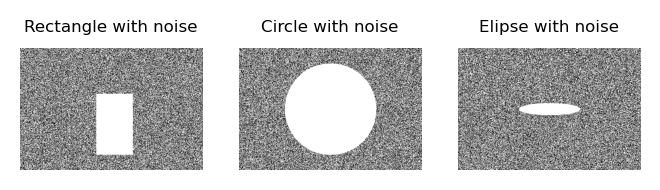

In [12]:
def generateNoise(x_size, y_size, image):
  for x in range(x_size):
    for y in range(y_size):
      if (np.random.normal()>0.5 ):
        image[y,x]=1;     
  return image

rectangleNoise = generateNoise(x_size, y_size, rectangle)
circleNoise = generateNoise(x_size, y_size, circle)
elipseNoise = generateNoise(x_size, y_size, elipse)

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(rectangleNoise, cmap='gray')
plt.axis('off')
plt.title("Rectangle with noise", fontsize=6)
plt.subplot(1, 3, 2)
plt.imshow(circleNoise, cmap='gray')
plt.axis('off')
plt.title("Circle with noise", fontsize=6)
plt.subplot(1, 3, 3)
plt.imshow(elipseNoise, cmap='gray')
plt.axis('off')
plt.title("Elipse with noise", fontsize=6)
plt.show()

Następnie skupimy się na analizie kształtu z kołem, a  konkretnie na kształcie pączka / pierścienia.

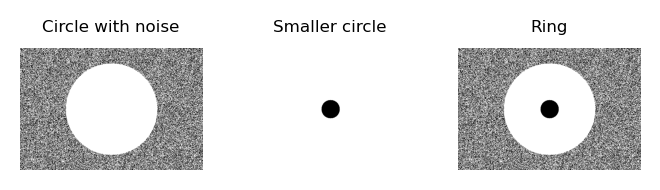

In [14]:
radius = 30
circle_smaller = generate_circle(x_size, y_size, x_origin, y_origin, radius)
circle_smaller = np.logical_not(circle_smaller)
ring = np.logical_and(circleNoise, circle_smaller)
#ring = circleNoise * circle_smaller # For binary images logical_and and multiply operations give the same result

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(circleNoise, cmap='gray')
plt.axis('off')
plt.title("Circle with noise", fontsize=6)
plt.subplot(1, 3, 2)
plt.imshow(circle_smaller, cmap='gray')
plt.axis('off')
plt.title("Smaller circle", fontsize=6)
plt.subplot(1, 3, 3)
plt.imshow(ring, cmap='gray')
plt.axis('off')
plt.title("Ring", fontsize=6)
plt.show()

# Operacje morfologiczne
Poprzez operacje morfologiczne możliwe jest usunięcie niedoskonałości z obrazów binarnych lub ich wygładzenia, co prowadzi do zmiany struktury lub formy obiektu na obrazie. Z tego wynika, że operacje morfologiczne skupiają się na analizie kształcie (morfologi). 

Operacje morfologiczne badają obraz przy pomocy małej maski (= kernela), zwanego elementem strukturalnym (se), w bardzo podobny sposób jak to robią filtry (omówione w poprzednich notatnikach). Element strukturalny przesuwa się po obrazie (podobnie jak jądro w konwolucji / maska w filtracji), ale zamiast wykonywać operacje liniowe (sumowanie liniowe w konwolucji), wykonuje operacje nieliniowe na pikselach (opisane w dalszej części). Element strukturalny to macierz składająca się z wartości 0 i 1, może przybierać różne kształty i rozmiary.  

Najpopularniejszym elementem strukturalnym jest ten z numerem 2, w postaci krzyżyka.

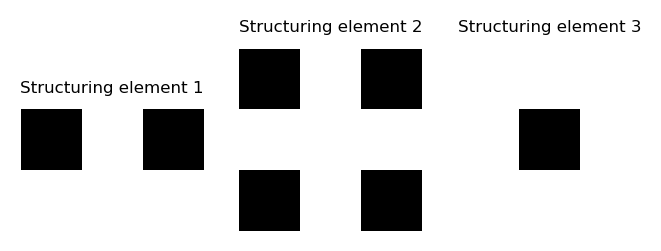

In [40]:
se1=np.array([[0,1,0]])
se2=np.array([[0,1,0],
              [1,1,1],
              [0,1,0]])
se3=np.array([[1,1,1],
              [1,0,1],
              [1,1,1]])

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(se1, cmap='gray')
plt.axis('off')
plt.title("Structuring element 1", fontsize=6)
plt.subplot(1, 3, 2)
plt.imshow(se2, cmap='gray')
plt.axis('off')
plt.title("Structuring element 2", fontsize=6)
plt.subplot(1, 3, 3)
plt.imshow(se3, cmap='gray')
plt.axis('off')
plt.title("Structuring element 3", fontsize=6)
plt.show()

# Operacje: dylatacja, erozja, otwarcie i zamknięcie

Operacje nieliniowe: max dylatacja, min erozja aby modyfikowac obraz wg okresloncyh kreterium geometrycznych. 

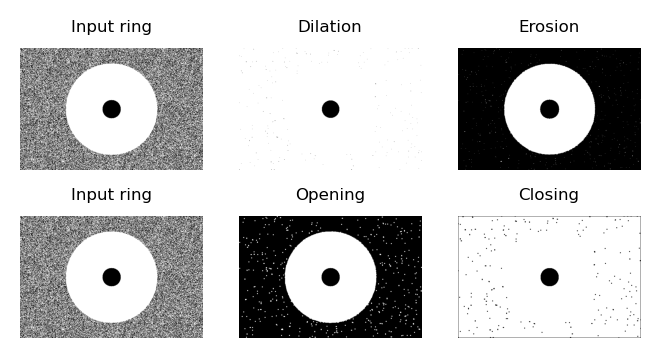

In [18]:
dilated_circle = nd.binary_dilation(ring , np.ones((3, 3)))
eroded_circle = nd.binary_erosion(ring , np.ones((3, 3)))
circle_after_opening = nd.binary_opening(ring , np.ones((3, 3)))
circle_after_closing = nd.binary_closing(ring , np.ones((3, 3)))

plt.figure(figsize=(4, 2), dpi=200)
plt.subplot(2, 3, 1)
plt.imshow(ring, cmap='gray')
plt.title("Input ring", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(dilated_circle, cmap='gray')
plt.title("Dilation", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(eroded_circle, cmap='gray')
plt.title("Erosion", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 4)
plt.imshow(ring, cmap='gray')
plt.title("Input ring", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(circle_after_opening, cmap='gray')
plt.title("Opening", fontsize=6)
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(circle_after_closing, cmap='gray')
plt.title("Closing", fontsize=6)
plt.axis('off')
plt.show()

(-0.5, 7.5, 9.5, -0.5)

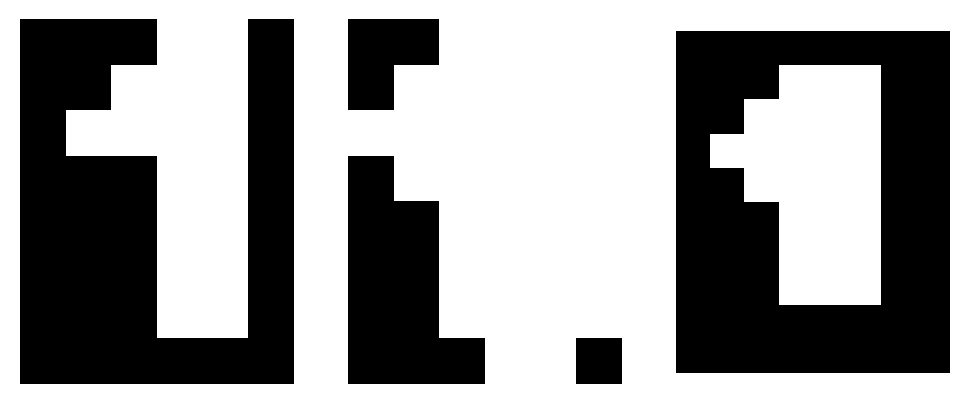

In [ ]:
def our_dilation(image, se):
 
  def generate_size(se, coord):
    if se.shape[coord]==1:
      return 1
    else:
      return int((se.shape[coord] - se.shape[coord]%2)/2)

  dim_y = generate_size(se, 0) 
  dim_x = generate_size(se, 1) 
  
  new_matrix_y=image.shape[0]+int(2*dim_y)
  new_matrix_x=image.shape[1]+int(2*dim_x)

  processed_image = np.zeros((new_matrix_y,new_matrix_x))
  processed_image[dim_y:(dim_y + image.shape[0]), dim_x:(dim_x + image.shape[1])] = image
  final_image = np.zeros((new_matrix_y,new_matrix_x))


  for y in range (dim_y,processed_image.shape[0]):
    for x in range (dim_x,processed_image.shape[1]):
      if ( ((y+2*dim_y)< processed_image.shape[0]) and ((x+2*dim_x) < processed_image.shape[1]) ) :
        temp = np.max((processed_image[y-dim_y:y+dim_y+1,x-dim_x:x+dim_x+1])* se )
        final_image[y,x] = temp
  
  return final_image

image=np.array([[0,0,0,1,1,0], [0,0,1,1,1,0], [0,1,1,1,1,0], [0,0,0,1,1,0],  [0,0,0,1,1,0], [0,0,0,1,1,0], [0,0,0,1,1,0],  [0,0,0,0,0,0]])
se=np.array([[0,1,0], [1,0,1],[0,1,0]])

IMG=our_dilation(image, se)

dilated_circle = nd.binary_dilation(image , se)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dilated_circle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(IMG, cmap='gray')
plt.axis('off')



(-0.5, 7.5, 9.5, -0.5)

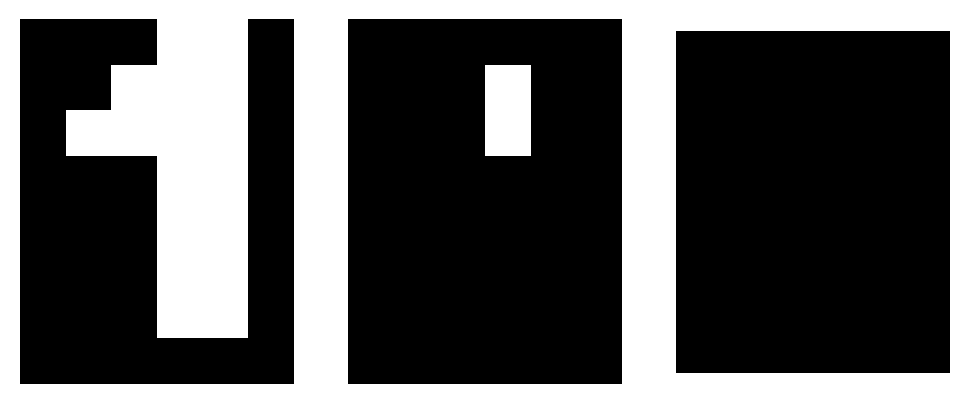

In [ ]:
def our_erosion(image, se):
 
  def generate_size(se, coord):
    if se.shape[coord]==1:
      return 1
    else:
      return int((se.shape[coord] - se.shape[coord]%2)/2)

  dim_y = generate_size(se, 0) 
  dim_x = generate_size(se, 1) 
  
  new_matrix_y=image.shape[0]+int(2*dim_y)
  new_matrix_x=image.shape[1]+int(2*dim_x)

  processed_image = np.ones((new_matrix_y,new_matrix_x))
  processed_image[dim_y:(dim_y + image.shape[0]), dim_x:(dim_x + image.shape[1])] = image
  final_image = np.zeros((new_matrix_y,new_matrix_x))


  for y in range (dim_y,processed_image.shape[0]):
    for x in range (dim_x,processed_image.shape[1]):
      if ( ((y+2*dim_y)< processed_image.shape[0]) and ((x+2*dim_x) < processed_image.shape[1]) ) :
        temp = np.min((processed_image[y-dim_y:y+dim_y+1,x-dim_x:x+dim_x+1])* se )
        final_image[y,x] = temp
  
  return final_image 


image=np.array([[0,0,0,1,1,0], [0,0,1,1,1,0], [0,1,1,1,1,0], [0,0,0,1,1,0],  [0,0,0,1,1,0], [0,0,0,1,1,0], [0,0,0,1,1,0],  [0,0,0,0,0,0]])
se=np.array([[0,1,0], [1,0,1],[0,1,0]])

IMG=our_erosion(image, se)

eroded_circle = nd.binary_erosion(image , se)

plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(eroded_circle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(IMG, cmap='gray')
plt.axis('off')


In [ ]:
def our_opening(image, se):
 
  image2 = our_erosion(image, se)
  final_image = our_dilation(image2, se)
  
  return final_image 

def our_closing(image, se):
 
  image2 = our_dilation(image, se)
  final_image = our_erosion(image2, se)
  
  return final_image 

IMG_op=our_opening(image, se)
IMG_cl=our_closing(image, se)

opening = nd.binary_opening(image, se)
closing = nd.binary_closing(image, se)

plt.figure(dpi=200)
plt.subplot(1, 4, 1)
plt.imshow(IMG_op, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(IMG_cl, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(closing, cmap='gray')
plt.axis('off')


# Wewnętrzne i zewnętrzne krawędzie obiektu

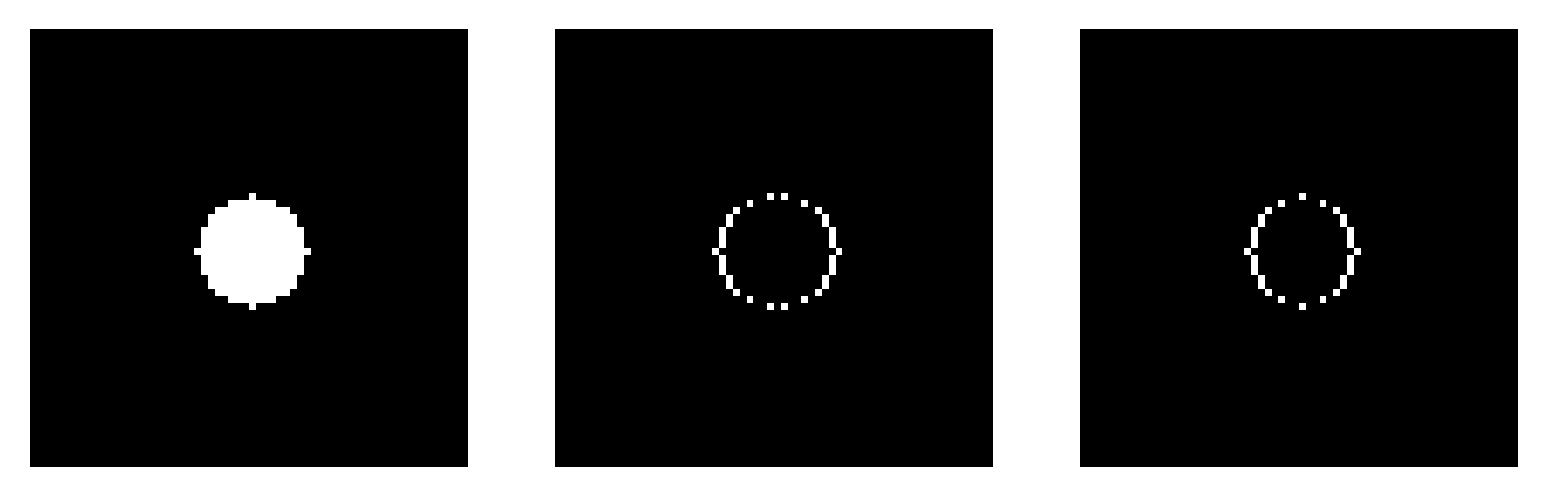

In [11]:
#Outer and inner edges
small_circle = generate_circle(64, 64, 32, 32, 8)
se = np.ones((1,3))

outer_edge = np.logical_and(nd.binary_dilation(small_circle, se), np.logical_not(small_circle))
inner_edge = np.logical_and(np.logical_not(nd.binary_erosion(small_circle, se)), small_circle)

plt.figure(dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(small_circle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(outer_edge, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(inner_edge, cmap='gray')
plt.axis('off')
plt.show()

